## Run a single example of the calibration for a certain set of parameters

In [1]:
include("ms_calibration.jl")

detuning_khz = 10
pi_time_blue_μs = 5
pi_time_red_μs = 7
sym_ac_stark_shift_khz = real_sym_ac_stark_shift_khz
antisym_ac_stark_shift_khz = real_antisym_ac_stark_shift_khz
θ = HamiltonianParameters([
    detuning_khz,
    pi_time_blue_μs,
    pi_time_red_μs,
    sym_ac_stark_shift_khz,
    antisym_ac_stark_shift_khz,
])

HamiltonianParameters(10.0, 5.0, 7.0, 1.0, -0.035)

In [2]:
# demonstrate that we achieve >99.99% fidelity with ideal parameters
@time ms_fidelity(θ, θ)

 35.237874 seconds (83.52 M allocations: 4.272 GiB, 4.06% gc time)


0.9999675852337855

In [3]:
include("ms_calibration.jl")
import PyPlot
const plt = PyPlot;

function rand_coeff()
    # returns a uniform random float in [0.9, 1.1]
    return 0.9 + (rand() * 0.2)
end

param_count = length(fieldnames(HamiltonianParameters))
initial_guess = HamiltonianParameters([as_vector(θ)[i] * rand_coeff() for i in 1:param_count])

N = 100
tspan_ideal = 0:0.1:200
tspan_experiment = 0:20:200

@time res = ms_calibration(θ, initial_guess, N, tspan_ideal, tspan_experiment)

ideal_fit_params = as_vector(res["ideal_fit_params"])
learned_fit_params = as_vector(res["learned_fit_params"])
error = [ideal_fit_params[i] - learned_fit_params[i] for i in 1:param_count]
relative_error = [error[i] / ideal_fit_params[i] for i in 1:param_count]

  7.593565 seconds (47.58 M allocations: 2.076 GiB, 7.15% gc time)


5-element Array{Float64,1}:
  0.0019871187474223007
 -0.008674138874943083
 -0.02310916821760881
  0.1440616099262193
 -0.03758093591117093

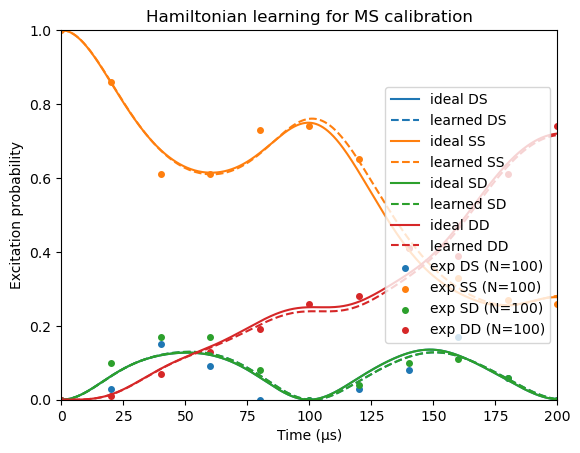

ideal fit parameters [10.0, 5.0, 7.0, 1.0, -0.035]
learned fit parameters [9.980128812525777, 5.043370694374715, 7.161764177523262, 0.8559383900737807, -0.036315332756890986]
fit parameters relative error=[0.0019871187474223007, -0.008674138874943083, -0.02310916821760881, 0.1440616099262193, -0.03758093591117093]


In [4]:
ideal = res["ideal_curve"]
learned = res["learned_curve"]
experimental = res["experimental_data"]

plt.figure()
for state in keys(experimental[1])
    plt.plot(tspan_ideal, getindex.(ideal, state), "-", label="ideal $state")
    plt.plot(tspan_ideal, getindex.(learned, state), "--", label="learned $state", color=plt.gca().lines[end].get_color())
    plt.scatter(tspan_experiment, getindex.(experimental, state), label="exp $state (N=$(N))", s=16, color=plt.gca().lines[end].get_color())
end

println("ideal fit parameters $(ideal_fit_params)")
println("learned fit parameters $(learned_fit_params)")
println("fit parameters relative error=$(relative_error)")

plt.title("Hamiltonian learning for MS calibration")
plt.xlim(tspan_ideal[1], tspan_ideal[end])
plt.ylim(0, 1)
plt.xlabel("Time (μs)")
plt.ylabel("Excitation probability")
plt.legend(loc="center right");

## Test the average error of the technique as a function of N

In [5]:
include("ms_calibration.jl")

n_repetitions = 20
n_shots_list = [5, 10, 25, 50, 100, 250, 500, 1000, 2000, 4000]

relative_error_results = Dict()
fidelities = Dict()
for n_shots in n_shots_list 
    print("Running for n_shots=$(n_shots)")
    relative_error_results[n_shots] = []
    fidelities[n_shots] = []
    for i = 1:n_repetitions
        print(".")
        
        initial_guess = HamiltonianParameters([as_vector(θ)[i] * rand_coeff() for i in 1:param_count])        
        tspan_ideal = 0:0.1:200
        tspan_experiment = 20:20:200
        res = ms_calibration(θ, initial_guess, n_shots, tspan_ideal, tspan_experiment)

        ideal_fit_params = as_vector(res["ideal_fit_params"])
        learned_fit_params = as_vector(res["learned_fit_params"])
        error = [ideal_fit_params[i] - learned_fit_params[i] for i in 1:param_count]
        relative_error = [error[i] / ideal_fit_params[i] for i in 1:param_count]
        push!(relative_error_results[n_shots], relative_error)
        
        # calculate the resulting error in MS-gate fidelity
        fidelity = ms_fidelity(θ, res["learned_fit_params"])
        push!(fidelities[n_shots], fidelity)
    end
    println(" complete!")
end

Running for n_shots=5.................... complete!
Running for n_shots=10.................... complete!
Running for n_shots=25.................... complete!
Running for n_shots=50.................... complete!
Running for n_shots=100.................... complete!
Running for n_shots=250.................... complete!
Running for n_shots=500.................... complete!
Running for n_shots=1000.................... complete!
Running for n_shots=2000.................... complete!
Running for n_shots=4000.................... complete!


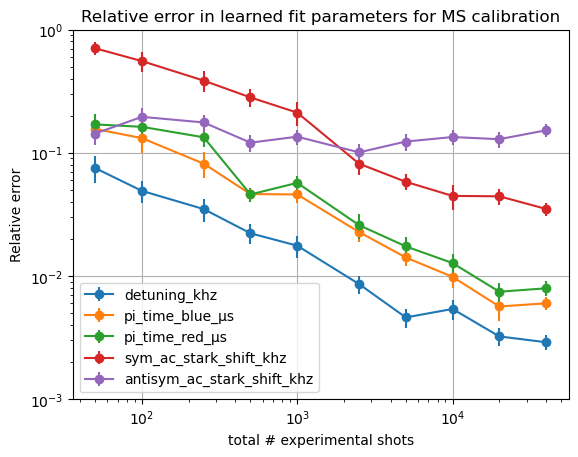

In [6]:
import PyPlot
const plt = PyPlot;
import Statistics

total_n_shots = [n_shots * length(tspan_experiment) for n_shots in n_shots_list]

plt.figure()

for (index, label) in enumerate(fieldnames(HamiltonianParameters))
    means = []
    stderrs = []
    for n_shots in n_shots_list
        relative_errors = [abs(errors[index]) for errors in relative_error_results[n_shots]]
        push!(means, mean(relative_errors))
        push!(stderrs, Statistics.std(relative_errors) / sqrt(length(relative_errors)))
    end
    plt.errorbar(x=total_n_shots, y=means, yerr=stderrs, linestyle="-", marker="o", label=label)
end

plt.title("Relative error in learned fit parameters for MS calibration")
plt.ylim(1e-3, 1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("total # experimental shots")
plt.ylabel("Relative error")
plt.legend()
plt.grid();

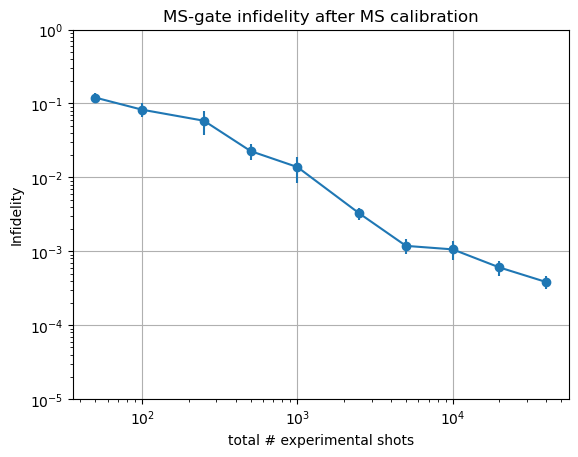

In [7]:
import PyPlot
const plt = PyPlot;
using Statistics

fidelity_means = []
fidelity_stderrs = []
for n_shots in n_shots_list
    push!(fidelity_means, mean(fidelities[n_shots]))
    push!(fidelity_stderrs, Statistics.std(fidelities[n_shots]) / sqrt(length(fidelities[n_shots])))
end

plt.figure()
plt.errorbar(x=total_n_shots, y=1 .- fidelity_means, yerr=fidelity_stderrs, linestyle="-", marker="o")

plt.title("MS-gate infidelity after MS calibration")
plt.ylim(1e-5, 1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("total # experimental shots")
plt.ylabel("Infidelity")
plt.grid();

## Print the raw result data

In [8]:
print(relative_error_results)

Dict{Any,Any}(2000 => Any[[-0.005585741680109635, -0.005385859085057376, 0.0037275634234771155, 0.03189222963880056, 0.06688948743798158], [-0.0046526337500854, 0.009220236704596197, 0.0034687712898126477, -0.011134363946468273, -0.011503486643662677], [0.004081327101627785, 0.001113929864138008, -0.0033937057388691017, -0.04239875763571521, 0.10266661250037329], [-0.009495501624201985, 0.020304574173345812, -0.02007934091346821, 0.1293451376884729, 0.2200795538817698], [-0.0008608203197102426, -0.0011418240349279074, -0.014319417186177574, 0.04641274322873412, 0.06721157873055311], [0.0008712458398941081, -0.007012729890769798, 0.005931682392358084, 0.034096827749903524, 0.11581517581325954], [-0.0006508492161891866, 0.0041981709514926635, 0.007884995980376555, 0.010607288912150459, 0.11650981162247473], [-0.003993196150613443, -0.00011261676398710563, 0.00499420911653787, -0.04711511676692459, -0.03226445338912793], [0.004056752157716304, -0.001901287243653016, 0.006705622448595199, 

, 0.19783158138792906], [-0.015255784086588342, -0.028569524883361907, 0.06500512775409144, -0.19179769366214905, 0.05424207657660753], [-0.02899668641303137, -0.010050154182302328, 0.03140058520863282, 0.03397749999926092, 0.21410584540720656], [0.014710657750035239, -0.04424575444844425, 0.0896811652251205, -0.11555026939984803, 0.11406689883278713], [0.019069404183962746, -0.036778039048177294, 0.016963880066785793, -0.05009062508862572, 0.18469612272905842], [0.0072600930323348575, 0.004599520486073061, -0.005594314390917303, 0.1618770605336346, 0.17315374461711022], [0.007290068083111834, -0.07291395697514957, 0.07867911676665226, -0.18449264623922335, 0.08898187625828267], [0.0182417637523379, -0.06910296056552863, 0.1160231911673232, -0.5346714734977454, -0.08863886722151564]],4000 => Any[[-0.002787166235952476, -0.00694417340743172, 0.008998899613183247, 0.03526746719040719, 0.16055389037507958], [0.00419321853168011, -0.010299928088644527, -0.0029000251262021643, 0.00369198133

], [0.012915834012369131, -0.016154312582721708, -0.022901762471386405, 0.01754698677105626, 0.1392527768337995]],1000 => Any[[0.0037755706996673412, 0.014268141674532941, 7.670857729813463e-5, -0.021032702478156473, 0.10432153281320097], [-0.01155804248051311, 0.005079295343487544, 0.00016961266498035803, 0.08305099261908078, 0.05068238177582098], [-0.0013393143270695519, -0.009481488855423947, 0.009392899448229741, -0.007935004862151818, 0.00830010954925595], [0.006176926610896416, 0.007334791643302019, -0.012203595551444124, 0.07300030660772983, 0.26246315527195935], [0.008156991024052474, 0.0055613626248455, -0.021445039374515775, -0.016086046985123614, 0.24946337028764373], [0.009160211960244701, 0.011644931088449263, -0.02540952533565794, 0.012757216002930338, 0.05891412915716352], [0.00404407098657753, -0.0018480177679805366, -0.014509093093794587, -0.03112050541630551, 0.22688511174445622], [0.009745745743252954, -0.026738499573308337, 0.014852749309514048, 0.01591269065215517,

In [9]:
print(fidelities)

Dict{Any,Any}(2000 => Any[0.9991248973279764, 0.9997546071102288, 0.9995492179033119, 0.9969570497528986, 0.9994439083579407, 0.9995812914128304, 0.999868278106397, 0.9996753362081077, 0.9991675143279366, 0.9988426310855683, 0.9993969020360732, 0.9999113693101933, 0.9997479095214731, 0.9989137285839287, 0.9999121247659127, 0.9996988867015887, 0.9995390510482641, 0.999557062135133, 0.999567302216345, 0.999711208429138],25 => Any[0.950847918806158, 0.9942260397733842, 0.9452954837517712, 0.9922298566319804, 0.9766275330988482, 0.8940554182280964, 0.9823761268900675, 0.9520841404751986, 0.9443162199341962, 0.983087215382953, 0.7478997959830715, 0.9792091382359995, 0.9879222934526481, 0.9568453204357129, 0.9907727466679782, 0.6293086476642322, 0.9494420948222544, 0.9935958543211493, 0.9980995372663289, 0.9846523154784477],10 => Any[0.734964366609374, 0.9261115111690098, 0.9957065177277569, 0.994756980584103, 0.9555513525614925, 0.8647845272777349, 0.8897306007446799, 0.9727059949535048, 0.